In [1]:
# !pip install pandas numpy seaborn matplotlib scikit-learn

In [2]:
# pip list

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
# Step 1: Merge Actigraph Data
control_folder = "data/control"
condition_folder = "data/condition"

In [5]:
def merge_actigraph_data(folder_path):
    all_data = pd.DataFrame()  # Initialize an empty DataFrame
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            all_data = pd.concat([all_data, df], ignore_index=True)  # Concatenate data
    return all_data

In [6]:
control_data = merge_actigraph_data(control_folder)
condition_data = merge_actigraph_data(condition_folder)

In [7]:
# Step 2: Check for Missing Values
print("Control Data - Missing Values:")
print(control_data.isnull().sum())

print("\nCondition Data - Missing Values:")
condition_data.isnull().sum()

Control Data - Missing Values:
timestamp    0
date         0
activity     0
dtype: int64

Condition Data - Missing Values:


timestamp    0
date         0
activity     0
dtype: int64

In [8]:
# Step 3: Convert Data Types
control_data["timestamp"] = pd.to_datetime(control_data["timestamp"])
condition_data["timestamp"] = pd.to_datetime(condition_data["timestamp"])

In [9]:
# Step 4: Correlational Analysis (After merging with scores.csv and performing imputation)
scores_file = "data/scores.csv"
scores_data = pd.read_csv(scores_file)

In [10]:
condition_data_merged = pd.concat([condition_data, scores_data], axis=1)
condition_data_merged.head()

,timestamp,date,activity,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,2002-06-06 13:00:00,2002-06-06,161,condition_1,11.0,2.0,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,2002-06-06 13:01:00,2002-06-06,80,condition_2,18.0,2.0,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
2,2002-06-06 13:02:00,2002-06-06,175,condition_3,13.0,1.0,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
3,2002-06-06 13:03:00,2002-06-06,728,condition_4,13.0,2.0,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
4,2002-06-06 13:04:00,2002-06-06,911,condition_5,13.0,2.0,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


In [11]:
# Check for null values
condition_data_merged.isnull().any()

timestamp    False
date         False
activity     False
number        True
days          True
gender        True
age           True
afftype       True
melanch       True
inpatient     True
edu           True
marriage      True
work          True
madrs1        True
madrs2        True
dtype: bool

In [12]:
def impute_missing_values(data):
    # Separate numeric and categorical columns
    numeric_cols = data.select_dtypes(include=["number"]).columns
    categorical_cols = data.select_dtypes(include=["object"]).columns

    # Define imputers for numeric and categorical data
    numeric_imputer = SimpleImputer(
        strategy="mean"
    )  # Impute missing numeric values with mean
    categorical_imputer = SimpleImputer(
        strategy="most_frequent"
    )  # Impute missing categorical values with most frequent

    # Impute missing values based on data types
    data_numeric = data[numeric_cols].copy()
    data_categoric = data[categorical_cols].copy()

    data_numeric[:] = numeric_imputer.fit_transform(data_numeric)
    data_categoric[:] = categorical_imputer.fit_transform(data_categoric)

    # Combine imputed data back into a single DataFrame
    data_imputed = pd.concat([data_numeric, data_categoric], axis=1)

    return data_imputed

In [13]:
condition_data_merged = impute_missing_values(condition_data_merged)

In [14]:
condition_corr = condition_data_merged[["activity", "madrs1", "madrs2"]].corr()
print("Correlation Matrix within the Condition Group:")
print(condition_corr)

Correlation Matrix within the Condition Group:
          activity    madrs1    madrs2
activity  1.000000 -0.001238 -0.000331
madrs1   -0.001238  1.000000  0.653090
madrs2   -0.000331  0.653090  1.000000


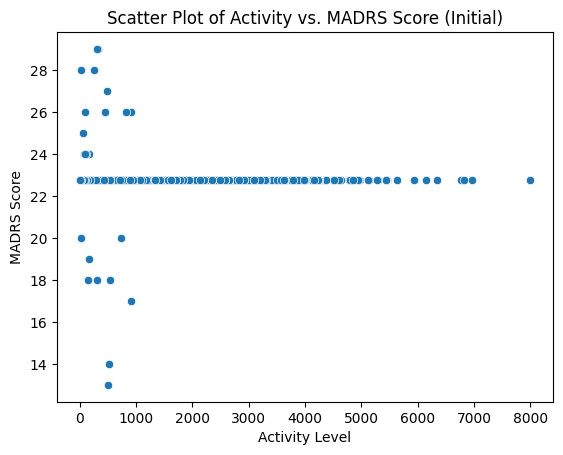

In [15]:
# Step 5: Visualization - Scatter Plot
sns.scatterplot(data=condition_data_merged, x="activity", y="madrs1")
plt.title("Scatter Plot of Activity vs. MADRS Score (Initial)")
plt.xlabel("Activity Level")
plt.ylabel("MADRS Score")
plt.show()

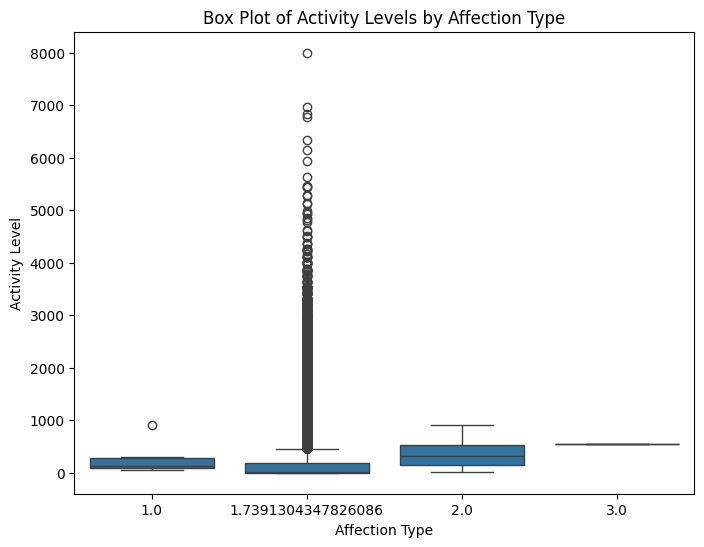

In [16]:
# Step 6: Group Comparisons - Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=condition_data_merged, x="afftype", y="activity")
plt.title("Box Plot of Activity Levels by Affection Type")
plt.xlabel("Affection Type")
plt.ylabel("Activity Level")
plt.show()

In [17]:
# Step 7: Regression Analysis
X = condition_data_merged[["activity"]]
y = condition_data_merged["madrs1"]  # Assuming using initial MADRS score for analysis

In [18]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [19]:
# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [20]:
# Make predictions
y_pred = model.predict(X_test)

In [21]:
# Evaluate model
print("\nLinear Regression Model Performance:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))


Linear Regression Model Performance:
Mean Squared Error: 9.681350630274913e-05
R-squared: -3.46651835021472e-05


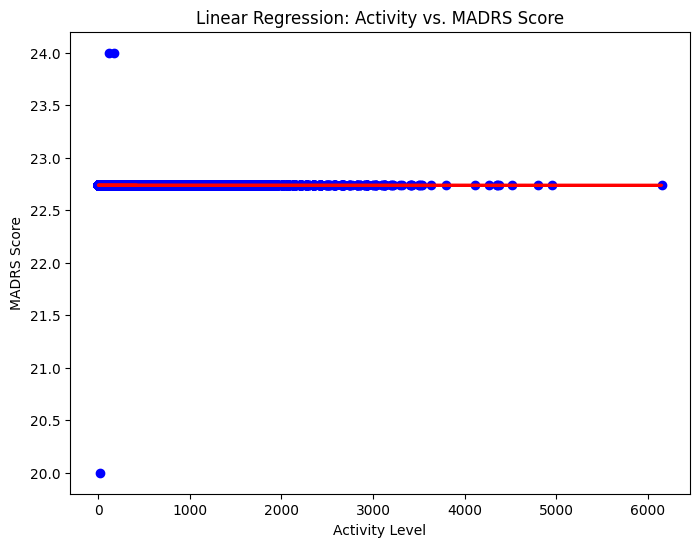

In [22]:
# Step 8: Visualization - Regression Line
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color="blue")
plt.plot(X_test, y_pred, color="red", linewidth=2)
plt.title("Linear Regression: Activity vs. MADRS Score")
plt.xlabel("Activity Level")
plt.ylabel("MADRS Score")
plt.show()